In [4]:
!unzip -q playground-series-s4e5.zip

In [1]:
!pip install -q scikit-learn pandas

In [33]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge

In [20]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [25]:
df=train.info()
df=test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [22]:
# Preprocessing
for col in train_df.columns:
    if train_df[col].isnull().any():
        if train_df[col].dtype in ['int64', 'float64']:
            train_df[col] = train_df[col].fillna(train_df[col].mean())

for col in test_df.columns:
    if test_df[col].isnull().any():
         if test_df[col].dtype in ['int64', 'float64']:
            test_df[col] = test_df[col].fillna(test_df[col].mean())


In [ ]:
# Handle categorical features
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if 'id' in categorical_cols:
    categorical_cols.remove('id')

for col in categorical_cols:
    le = LabelEncoder()
    # Combine train and test data 
    combined_series = pd.concat([train_df[col], test_df[col]], axis=0).astype(str).unique()
    le.fit(combined_series)

    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

In [ ]:
# Define features (X) and target (y)

X = train_df.drop(['id', 'FloodProbability'], axis=1)
y = train_df['FloodProbability']


In [27]:
# Split training data for validation (optional but good practice)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
start_time = time.time()
# Use Ridge Regression model
model = Ridge(alpha=1.0) # You can tune the alpha parameter
model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

print(f'Model Training Time: {training_time:.2f} seconds')

Model Training Time: 0.23 seconds


In [35]:
# Make predictions on the validation set
y_pred = model.predict(X_val)


In [36]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 0.00
R-squared: 0.84


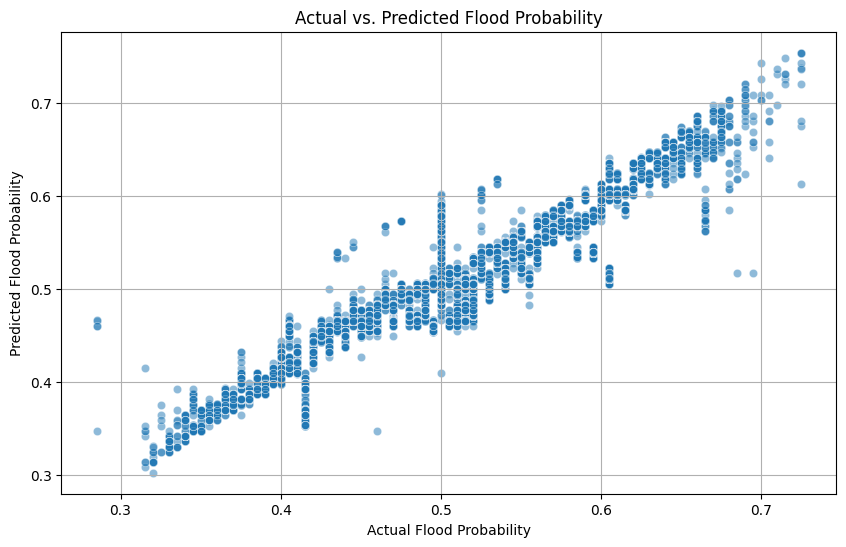

In [37]:
# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Flood Probability')
plt.xlabel('Actual Flood Probability')
plt.ylabel('Predicted Flood Probability')
plt.grid(True)
plt.show()

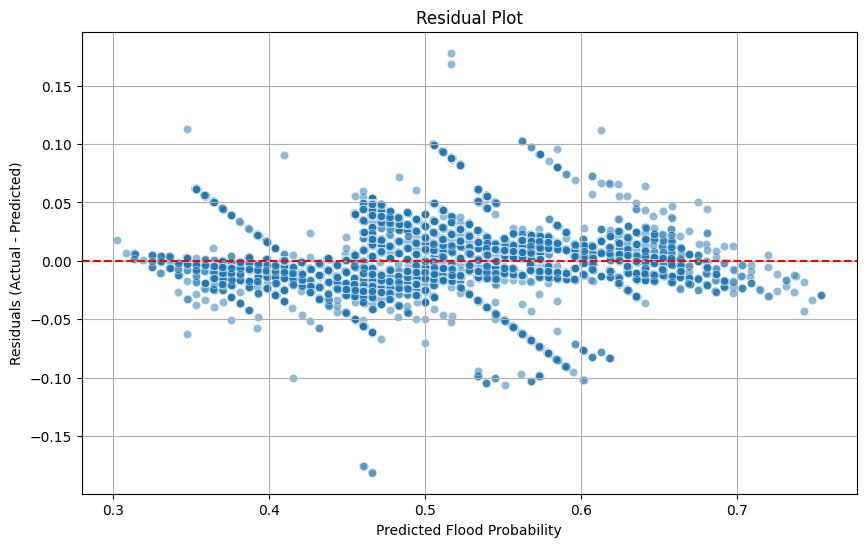

In [38]:
# Residual Plot
residuals = y_val - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Flood Probability')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

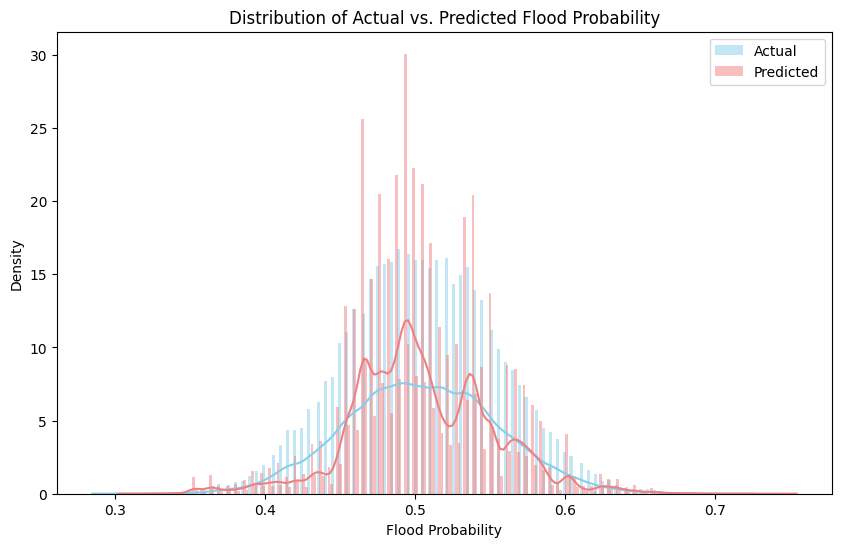

In [39]:
# Distribution of Actual vs. Predicted
plt.figure(figsize=(10, 6))
sns.histplot(y_val, kde=True, color='skyblue', label='Actual', stat='density', linewidth=0)
sns.histplot(y_pred, kde=True, color='lightcoral', label='Predicted', stat='density', linewidth=0)
plt.title('Distribution of Actual vs. Predicted Flood Probability')
plt.xlabel('Flood Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

In [42]:
# Feature Importance Plot (for tree-based models)
if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    sorted_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_importances, y=sorted_importances.index)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Learning Curve Plot
# Import learning_curve
from sklearn.model_selection import learning_curve
print("Generating Learning Curve...")
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)
)
print(learning_curve)

Generating Learning Curve...
<function learning_curve at 0x7913155f4e00>


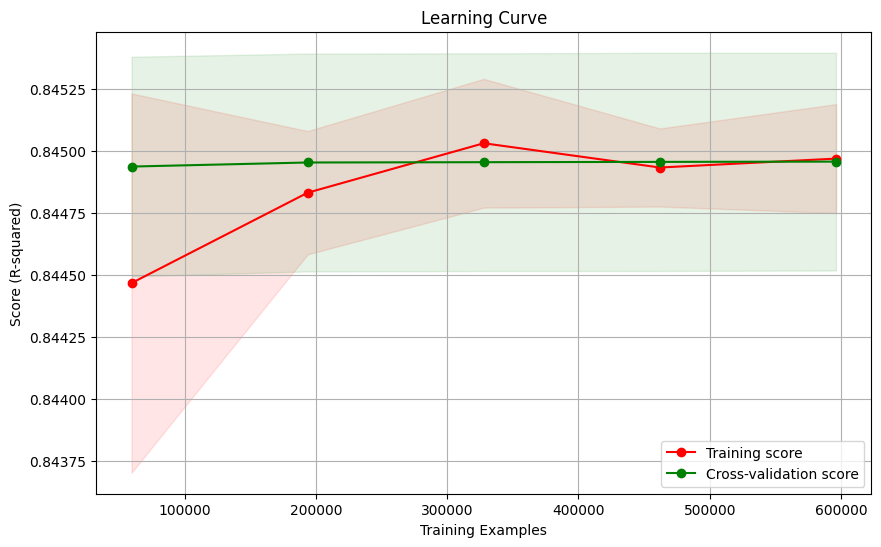

In [43]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score (R-squared)") # Using R-squared as the default score for regression
plt.legend(loc="best")
plt.grid(True)
plt.show()
